<a href="https://colab.research.google.com/github/DinisMartinho/This-Ganyu-Does-Not-Exist/blob/main/Colab%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, torchvision, math, matplotlib.pyplot

In [2]:
# GPU access is necessary to run the notebook.
use_collab_gpu = True #@param {type:"boolean"}

In [3]:
if use_collab_gpu == True:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

###### **● Generative Model**

In [4]:
factors = [1, 1, 1, 1, 1/2, 1/4, 1/8, 1/16, 1/32]

In [5]:
class WSConv2d(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2):
    super().__init__()

    self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.scale = (gain / (in_channels * kernel_size**2)) ** 0.5
    self.bias = self.conv.bias
    self.conv.bias = None

    torch.nn.init.normal_(self.conv.weight)
    torch.nn.init.zeros_(self.bias)
  
  def forward(self, x):
    return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [6]:
class WSTransposeConv2d(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2):
    super().__init__()

    self.conv = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
    self.scale = (gain / (in_channels * kernel_size**2)) ** 0.5
    self.bias = self.conv.bias
    self.conv.bias = None

    torch.nn.init.normal_(self.conv.weight)
    torch.nn.init.zeros_(self.bias)
  
  def forward(self, x):
    output_size = self.conv(x * self.scale).size()
    return self.conv(x * self.scale)[:, :, :output_size[2] - (2 * self.conv.padding[0]), :output_size[3] - (2 * self.conv.padding[0])] + self.bias.view(1, self.bias.shape[0], 1, 1)

In [7]:
class PixelNorm(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.epsilon = 1E-8

  def forward(self, x):
    return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

In [8]:
class ConvBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, use_pixelnorm=True):
    super().__init__()

    self.conv1 = WSConv2d(in_channels, out_channels)
    self.conv2 = WSConv2d(out_channels, out_channels)

    self.LReLU = torch.nn.LeakyReLU(0.2)
    self.pn = PixelNorm()
    self.use_pixelnorm = use_pixelnorm
  
  def forward(self, x):
    x = self.LReLU(self.conv1(x))
    x = self.pn(x) if self.use_pixelnorm else x
    x = self.LReLU(self.conv2(x))
    x = self.pn(x) if self.use_pixelnorm else x
    return x

In [9]:
class Generator(torch.nn.Module):
  def __init__(self, z_dim, in_channels, img_channels=3):
    super().__init__()

    self.initial = torch.nn.Sequential(
        WSTransposeConv2d(z_dim, in_channels, 4, 1, 0),
        torch.nn.LeakyReLU(0.2),
        WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
        torch.nn.LeakyReLU(0.2),
        PixelNorm(),
    )

    self.initial_rgb = WSConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0)
    self.prog_blocks, self.rgb_layers = torch.nn.ModuleList(), torch.nn.ModuleList([self.initial_rgb])

    for i in range(len(factors) - 1):
      conv_in_c = int(in_channels * factors[i])
      conv_out_c = int(in_channels * factors[i+1])
      self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
      self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0))

  def fade_in(self, alpha, upscaled, generated):
    return torch.tanh(alpha*generated + (1-alpha) * upscaled)

  def forward(self, x, alpha, steps):
    out = self.initial(x)
    if steps == 0:
      return self.initial_rgb(out)
    
    for step in range(steps):
      upscaled = torch.nn.functional.interpolate(out, scale_factor=2, mode="nearest")
      out = self.prog_blocks[step](upscaled)
    
    final_upscaled = self.rgb_layers[steps - 1](upscaled)
    final_out = self.rgb_layers[steps](out)

    return self.fade_in(alpha, final_upscaled, final_out)

###### **● Download Pre-trained Weights**

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
!gdown --no-cookies 1-FASpgSrAxbCNotevAx0qee6tYZAh3E5

###### **● Manual Inference**

In [12]:
model = Generator(256, 256, 3).to(device)

In [13]:
model.load_state_dict(torch.load("./Pre-Trained Model Generator.pth"))

<All keys matched successfully>

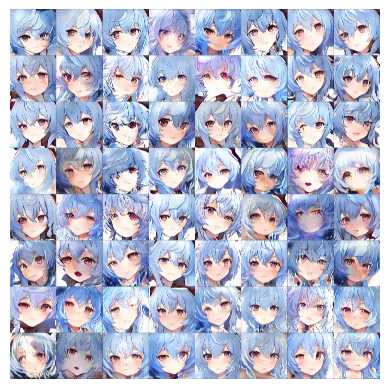

In [14]:
model.eval()
with torch.no_grad():
  output = model(torch.randn(8, 256, 1, 1).to(device), 1, 8) * 0.5 + 0.5
  torch.cuda.empty_cache()
torchvision.utils.save_image(output, "output_img.png")

img = matplotlib.image.imread("output_img.png")
imgplot = matplotlib.pyplot.imshow(img)
matplotlib.pyplot.axis("off")
matplotlib.pyplot.show()